# Model Retraining and Drift Detection: A Hands-On Lab

This notebook demonstrates core concepts in maintaining machine learning models in production:

## Learning Objectives

1. **Understanding Model Drift**
   - Concept Drift: Changes in the relationship between features and target
   - Data Drift: Changes in the input data distribution
   
2. **Detecting Model Drift**
   - Statistical tests for data drift (KS-test, Chi-square)
   - Population Stability Index (PSI)
   - Performance monitoring for concept drift
   
3. **Strategies for Model Retraining**
   - Periodic retraining
   - Trigger-based retraining
   - Incremental learning
   
4. **Automating Retraining Pipelines**
   - Building automated monitoring systems
   - Implementing retraining triggers
   - Version control for models

## Dataset

We'll use the **Credit Card Fraud Detection** dataset from Kaggle (simulated version), which is ideal for demonstrating drift as fraud patterns change over time.

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Understanding Model Drift

### What is Model Drift?

Model drift occurs when the statistical properties of the target variable or input features change over time, causing model performance to degrade.

### Types of Drift:

**1. Data Drift (Covariate Shift)**
- The distribution of input features P(X) changes
- Example: Customer demographics shift as your business expands to new markets
- The relationship between features and target remains the same

**2. Concept Drift (Prior Probability Shift)**
- The relationship between features and target P(Y|X) changes
- Example: Fraud patterns evolve as criminals adapt to detection systems
- Model predictions become less accurate even if data distribution stays constant

**3. Label Drift**
- The distribution of the target variable P(Y) changes
- Example: Seasonal changes in product demand

Let's visualize these concepts with simulated data.

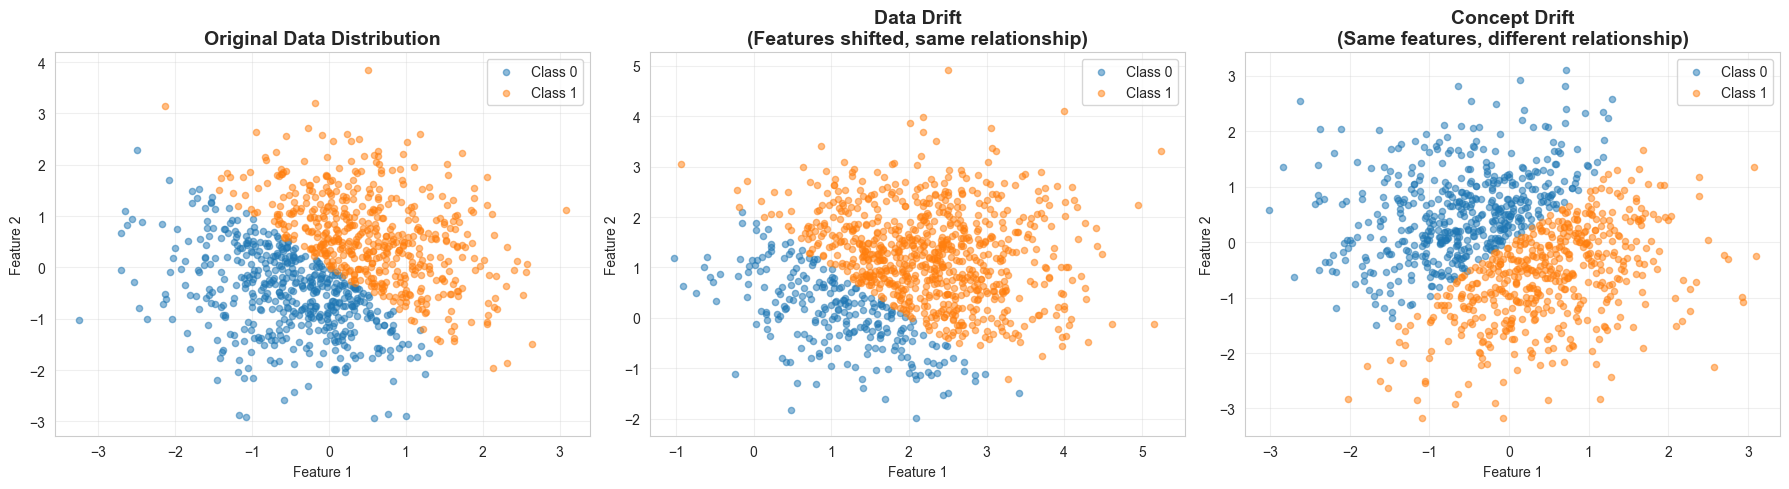


✓ Visualization complete

Key Observations:
- Original: Baseline data distribution
- Data Drift: Data has shifted in feature space, but decision boundary relationship is preserved
- Concept Drift: Feature distribution similar, but the decision boundary has rotated (relationship changed)


In [4]:
# This cell demonstrates the difference between data drift and concept drift

# Generate baseline data
np.random.seed(42)
n_samples = 1000

# Original data distribution
X_original = np.random.randn(n_samples, 2)
y_original = (X_original[:, 0] + X_original[:, 1] > 0).astype(int)

# Data drift: shift in feature distribution but same relationship
X_data_drift = np.random.randn(n_samples, 2) + np.array([2, 1])  # Shifted distribution
y_data_drift = (X_data_drift[:, 0] + X_data_drift[:, 1] > 2).astype(int)  # Same decision boundary, shifted

# Concept drift: same feature distribution but different relationship
X_concept_drift = np.random.randn(n_samples, 2)
y_concept_drift = (X_concept_drift[:, 0] - X_concept_drift[:, 1] > 0).astype(int)  # Different decision boundary

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data
axes[0].scatter(X_original[y_original==0, 0], X_original[y_original==0, 1], 
                alpha=0.5, label='Class 0', s=20)
axes[0].scatter(X_original[y_original==1, 0], X_original[y_original==1, 1], 
                alpha=0.5, label='Class 1', s=20)
axes[0].set_title('Original Data Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Data drift
axes[1].scatter(X_data_drift[y_data_drift==0, 0], X_data_drift[y_data_drift==0, 1], 
                alpha=0.5, label='Class 0', s=20)
axes[1].scatter(X_data_drift[y_data_drift==1, 0], X_data_drift[y_data_drift==1, 1], 
                alpha=0.5, label='Class 1', s=20)
axes[1].set_title('Data Drift\n(Features shifted, same relationship)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Concept drift
axes[2].scatter(X_concept_drift[y_concept_drift==0, 0], X_concept_drift[y_concept_drift==0, 1], 
                alpha=0.5, label='Class 0', s=20)
axes[2].scatter(X_concept_drift[y_concept_drift==1, 0], X_concept_drift[y_concept_drift==1, 1], 
                alpha=0.5, label='Class 1', s=20)
axes[2].set_title('Concept Drift\n(Same features, different relationship)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")
print("\nKey Observations:")
print("- Original: Baseline data distribution")
print("- Data Drift: Data has shifted in feature space, but decision boundary relationship is preserved")
print("- Concept Drift: Feature distribution similar, but the decision boundary has rotated (relationship changed)")

## 2. Loading and Preparing a Real-World Dataset

We'll create a simulated credit card fraud detection dataset that mimics real-world patterns:
- Highly imbalanced (fraud is rare)
- Multiple features representing transaction characteristics
- Temporal component to simulate drift over time

In [5]:
def create_fraud_detection_dataset(n_samples=10000, fraud_rate=0.02, drift_type=None, drift_magnitude=0.0):
    """
    Create a simulated fraud detection dataset.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    fraud_rate : float
        Proportion of fraudulent transactions
    drift_type : str or None
        Type of drift to introduce ('data', 'concept', or None)
    drift_magnitude : float
        Magnitude of drift (0-1)
    """
    np.random.seed(42 + int(drift_magnitude * 100))
    
    # Generate features
    # Feature 1: Transaction amount (log-normal distribution)
    amount = np.random.lognormal(mean=4, sigma=1.5, size=n_samples)
    
    # Feature 2: Time of day (0-24 hours)
    hour_of_day = np.random.uniform(0, 24, n_samples)
    
    # Feature 3: Distance from home
    distance_from_home = np.random.exponential(scale=50, size=n_samples)
    
    # Feature 4: Number of transactions in last 24h
    transactions_last_24h = np.random.poisson(lam=5, size=n_samples)
    
    # Feature 5: Average transaction amount
    avg_transaction_amount = amount * np.random.uniform(0.8, 1.2, n_samples)
    
    # Apply data drift if specified
    if drift_type == 'data':
        amount = amount * (1 + drift_magnitude)
        distance_from_home = distance_from_home * (1 + drift_magnitude * 0.5)
        hour_of_day = (hour_of_day + drift_magnitude * 6) % 24
    
    # Create fraud labels
    n_fraud = int(n_samples * fraud_rate)
    # use integer dtype for label array to avoid float equality issues
    is_fraud = np.zeros(n_samples, dtype=int)
    if n_fraud > 0:
        is_fraud[:n_fraud] = 1
    np.random.shuffle(is_fraud)
    
    # Fraud patterns (concept)
    if drift_type == 'concept':
        # Original pattern: High amount + late hours + far from home = fraud
        # Drifted pattern: Moderate amount + unusual times + many transactions = fraud
        fraud_score = (
            (1 - drift_magnitude) * (amount > np.percentile(amount, 80)) * 
            (hour_of_day > 22) * (distance_from_home > 100) +
            drift_magnitude * (amount > np.percentile(amount, 60)) * 
            (transactions_last_24h > 8) * ((hour_of_day < 4) | (hour_of_day > 20))
        )
    else:
        # Standard fraud pattern
        fraud_score = (
            (amount > np.percentile(amount, 80)) * 
            (hour_of_day > 22) * 
            (distance_from_home > 100)
        )
    
    # Make actual frauds more likely to have high fraud scores
    fraud_indices = np.where(is_fraud == 1)[0]
    # ensure fraud_score is float so we can add a float bump without dtype errors
    fraud_score = fraud_score.astype(float)
    if len(fraud_indices) > 0:
        fraud_score[fraud_indices] += np.random.uniform(0.5, 1.0, len(fraud_indices))
    
    # Create DataFrame
    df = pd.DataFrame({
        'amount': amount,
        'hour_of_day': hour_of_day,
        'distance_from_home': distance_from_home,
        'transactions_last_24h': transactions_last_24h,
        'avg_transaction_amount': avg_transaction_amount,
        'fraud_score_latent': fraud_score,
        'is_fraud': is_fraud.astype(int)
    })
    
    return df

# Generate baseline dataset (training data)
print("Generating datasets...")
df_train = create_fraud_detection_dataset(n_samples=10000, fraud_rate=0.02)
df_test = create_fraud_detection_dataset(n_samples=3000, fraud_rate=0.02)

print(f"\n✓ Training data: {df_train.shape}")
print(f"✓ Test data: {df_test.shape}")
print(f"\nFraud rate in training: {df_train['is_fraud'].mean():.2%}")
print(f"Fraud rate in test: {df_test['is_fraud'].mean():.2%}")

# Display first few rows
print("\nSample of training data:")
df_train.head(10)

Generating datasets...

✓ Training data: (10000, 7)
✓ Test data: (3000, 7)

Fraud rate in training: 2.00%
Fraud rate in test: 2.00%

Sample of training data:


,amount,hour_of_day,distance_from_home,transactions_last_24h,avg_transaction_amount,fraud_score_latent,is_fraud
0,115.015998,7.710124,9.407515,4,92.474258,0.0,0
1,44.371774,2.472461,21.293766,4,50.403886,0.0,0
2,144.247822,1.723381,175.497790,8,172.823002,0.0,0
3,536.220139,2.262623,75.885764,9,614.811464,0.0,0
4,38.427369,13.988865,16.605447,7,36.851893,0.0,0
5,38.428315,1.239892,41.498974,6,36.150623,0.0,0
6,583.368594,8.086245,25.903097,4,690.677617,0.0,0
7,172.630262,18.076793,33.663814,5,206.354822,0.0,0
8,26.998692,7.064356,21.938133,5,28.210763,0.0,0
9,123.203821,18.319394,16.378768,5,123.916803,0.0,0


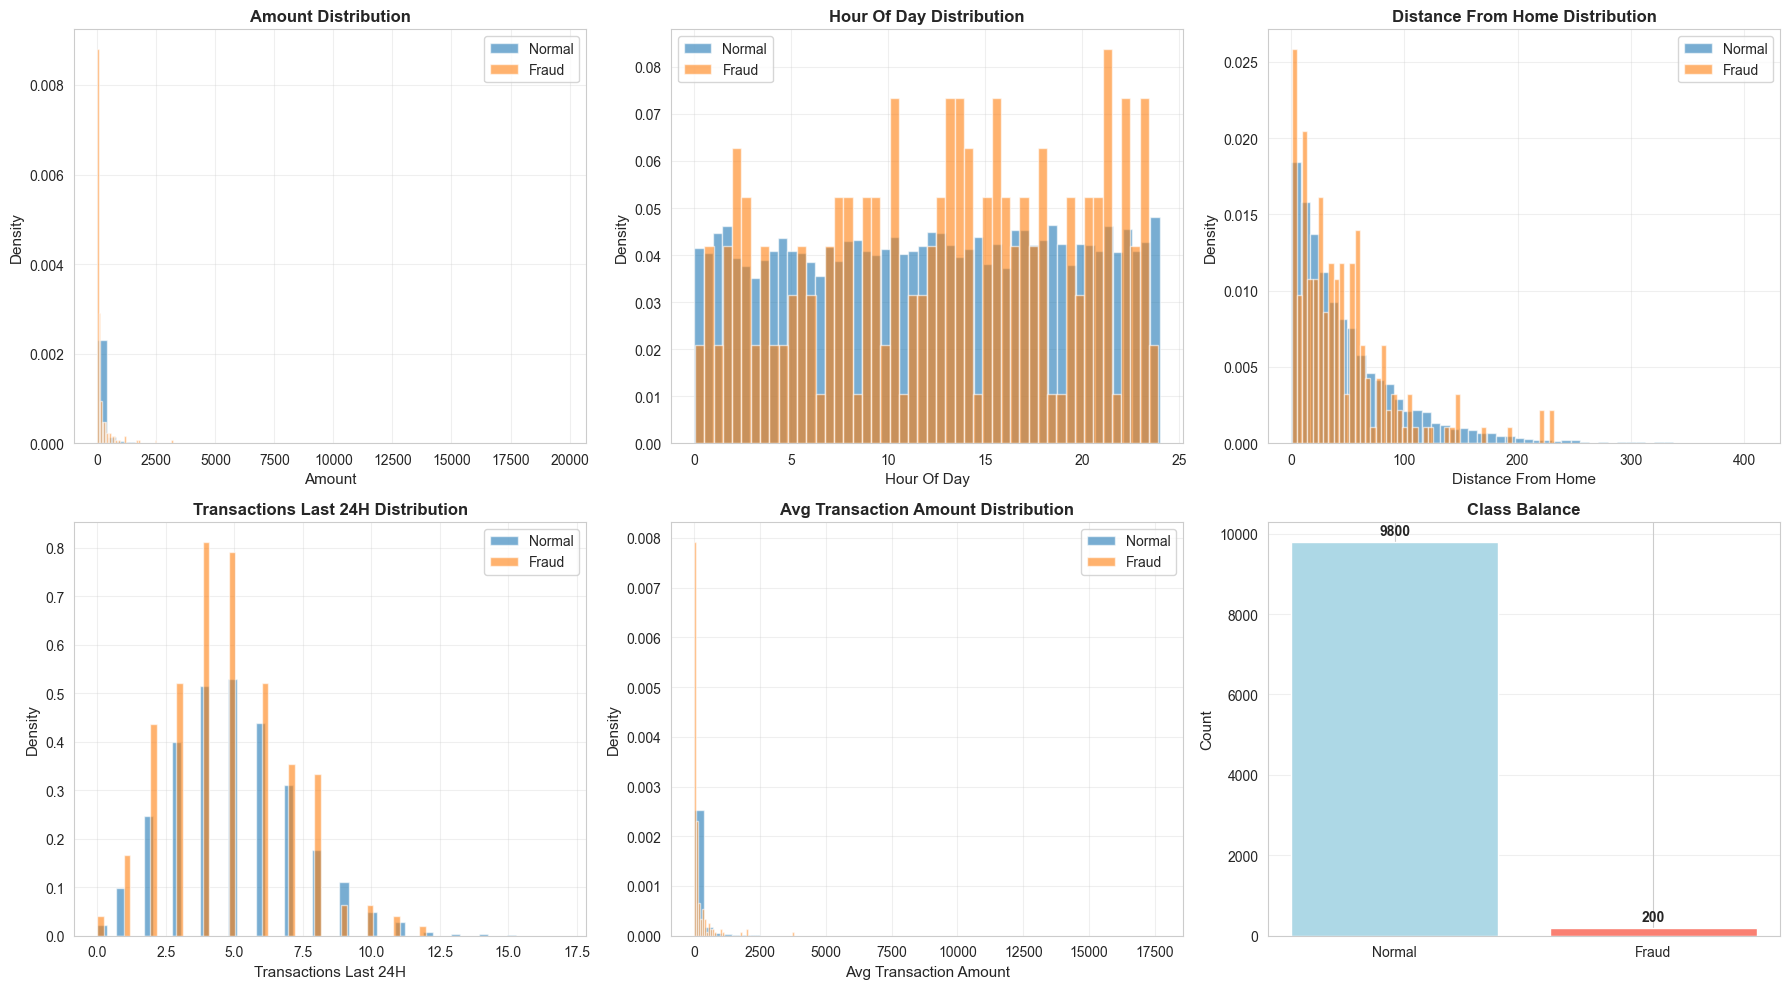


✓ EDA complete

Key Insights:
- Dataset is highly imbalanced (typical for fraud detection)
- Fraudulent transactions tend to have higher amounts
- Fraud is more common during late night hours
- Greater distance from home correlates with fraud


In [6]:
# This cell performs exploratory data analysis on the fraud detection dataset

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Feature distributions by fraud status
features = ['amount', 'hour_of_day', 'distance_from_home', 'transactions_last_24h', 'avg_transaction_amount']

for idx, feature in enumerate(features):
    axes[idx].hist(df_train[df_train['is_fraud']==0][feature], bins=50, alpha=0.6, label='Normal', density=True)
    axes[idx].hist(df_train[df_train['is_fraud']==1][feature], bins=50, alpha=0.6, label='Fraud', density=True)
    axes[idx].set_xlabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_ylabel('Density', fontsize=11)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution', fontweight='bold')

# Class balance
class_counts = df_train['is_fraud'].value_counts()
axes[5].bar(['Normal', 'Fraud'], class_counts.values, color=['lightblue', 'salmon'])
axes[5].set_ylabel('Count', fontsize=11)
axes[5].set_title('Class Balance', fontweight='bold')
axes[5].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_counts.values):
    axes[5].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ EDA complete")
print("\nKey Insights:")
print("- Dataset is highly imbalanced (typical for fraud detection)")
print("- Fraudulent transactions tend to have higher amounts")
print("- Fraud is more common during late night hours")
print("- Greater distance from home correlates with fraud")

## 3. Training a Baseline Model

Let's train a baseline fraud detection model that we'll use to demonstrate drift detection and retraining.

In [7]:
# Prepare features and target
feature_cols = ['amount', 'hour_of_day', 'distance_from_home', 'transactions_last_24h', 'avg_transaction_amount']
X_train = df_train[feature_cols]
y_train = df_train['is_fraud']
X_test = df_test[feature_cols]
y_test = df_test['is_fraud']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline model
print("Training baseline Random Forest model...")
baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42
)
baseline_model.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_train = baseline_model.predict(X_train_scaled)
y_pred_test = baseline_model.predict(X_test_scaled)
y_pred_proba_test = baseline_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE")
print("="*60)

print("\nTraining Set:")
print(f"  Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"  Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"  Recall:    {recall_score(y_train, y_pred_train):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_pred_train):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_test):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# Store baseline performance for comparison
baseline_performance = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'precision': precision_score(y_test, y_pred_test),
    'recall': recall_score(y_test, y_pred_test),
    'f1': f1_score(y_test, y_pred_test),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_test)
}

print("\n✓ Baseline model trained successfully")

Training baseline Random Forest model...

BASELINE MODEL PERFORMANCE

Training Set:
  Accuracy:  0.9748
  Precision: 0.4356
  Recall:    0.8800
  F1-Score:  0.5828

Test Set:
  Accuracy:  0.9500
  Precision: 0.0213
  Recall:    0.0333
  F1-Score:  0.0260
  ROC-AUC:   0.4802

✓ Baseline model trained successfully

BASELINE MODEL PERFORMANCE

Training Set:
  Accuracy:  0.9748
  Precision: 0.4356
  Recall:    0.8800
  F1-Score:  0.5828

Test Set:
  Accuracy:  0.9500
  Precision: 0.0213
  Recall:    0.0333
  F1-Score:  0.0260
  ROC-AUC:   0.4802

✓ Baseline model trained successfully


## 4. Detecting Data Drift

Data drift occurs when the distribution of input features changes over time. We'll implement several methods to detect this:

### Methods:
1. **Kolmogorov-Smirnov (KS) Test**: Statistical test comparing two distributions
2. **Population Stability Index (PSI)**: Industry standard for monitoring feature drift
3. **Chi-Square Test**: For categorical variables

In [8]:
class DataDriftDetector:
    """
    Detect data drift using statistical methods.
    """
    
    def __init__(self, reference_data, feature_names=None):
        """
        Initialize with reference (training) data.
        
        Parameters:
        -----------
        reference_data : array-like or DataFrame
            Reference dataset for comparison
        feature_names : list, optional
            Names of features
        """
        self.reference_data = reference_data
        self.feature_names = feature_names
        if hasattr(reference_data, 'columns'):
            self.feature_names = reference_data.columns.tolist()
    
    def ks_test(self, new_data, alpha=0.05):
        """
        Perform Kolmogorov-Smirnov test for each feature.
        
        Parameters:
        -----------
        new_data : array-like
            New data to test
        alpha : float
            Significance level
        
        Returns:
        --------
        dict : Test results
        """
        results = []
        
        n_features = self.reference_data.shape[1]
        
        for i in range(n_features):
            # Extract feature
            ref_feature = self.reference_data.iloc[:, i] if hasattr(self.reference_data, 'iloc') else self.reference_data[:, i]
            new_feature = new_data.iloc[:, i] if hasattr(new_data, 'iloc') else new_data[:, i]
            
            # Perform KS test
            statistic, p_value = stats.ks_2samp(ref_feature, new_feature)
            
            feature_name = self.feature_names[i] if self.feature_names else f"Feature_{i}"
            
            results.append({
                'feature': feature_name,
                'ks_statistic': statistic,
                'p_value': p_value,
                'drift_detected': p_value < alpha
            })
        
        results_df = pd.DataFrame(results)
        
        return {
            'overall_drift': results_df['drift_detected'].any(),
            'n_drifted_features': results_df['drift_detected'].sum(),
            'results': results_df
        }
    
    def psi(self, new_data, n_bins=10, threshold=0.1):
        """
        Calculate Population Stability Index.
        
        PSI < 0.1: No significant change
        0.1 <= PSI < 0.25: Small change
        PSI >= 0.25: Large change (retraining recommended)
        
        Parameters:
        -----------
        new_data : array-like
            New data to test
        n_bins : int
            Number of bins for discretization
        threshold : float
            PSI threshold for drift detection
        
        Returns:
        --------
        dict : PSI results
        """
        results = []
        
        n_features = self.reference_data.shape[1]
        
        for i in range(n_features):
            # Extract feature
            ref_feature = self.reference_data.iloc[:, i] if hasattr(self.reference_data, 'iloc') else self.reference_data[:, i]
            new_feature = new_data.iloc[:, i] if hasattr(new_data, 'iloc') else new_data[:, i]
            
            # Create bins based on reference data
            _, bin_edges = np.histogram(ref_feature, bins=n_bins)
            
            # Bin both datasets
            ref_binned = np.histogram(ref_feature, bins=bin_edges)[0]
            new_binned = np.histogram(new_feature, bins=bin_edges)[0]
            
            # Convert to percentages
            ref_pct = ref_binned / len(ref_feature)
            new_pct = new_binned / len(new_feature)
            
            # Avoid division by zero
            ref_pct = np.where(ref_pct == 0, 0.0001, ref_pct)
            new_pct = np.where(new_pct == 0, 0.0001, new_pct)
            
            # Calculate PSI
            psi_value = np.sum((new_pct - ref_pct) * np.log(new_pct / ref_pct))
            
            feature_name = self.feature_names[i] if self.feature_names else f"Feature_{i}"
            
            # Interpret PSI
            if psi_value < 0.1:
                interpretation = "No significant change"
            elif psi_value < 0.25:
                interpretation = "Small change"
            else:
                interpretation = "Large change - retraining recommended"
            
            results.append({
                'feature': feature_name,
                'psi': psi_value,
                'interpretation': interpretation,
                'drift_detected': psi_value > threshold
            })
        
        results_df = pd.DataFrame(results)
        
        return {
            'overall_drift': results_df['drift_detected'].any(),
            'mean_psi': results_df['psi'].mean(),
            'max_psi': results_df['psi'].max(),
            'results': results_df
        }

print("✓ DataDriftDetector class defined")

✓ DataDriftDetector class defined


In [9]:
# Generate data with drift
print("Generating datasets with varying levels of drift...\n")

# No drift
df_no_drift = create_fraud_detection_dataset(n_samples=3000, fraud_rate=0.02, drift_type=None)

# Small data drift
df_small_drift = create_fraud_detection_dataset(n_samples=3000, fraud_rate=0.02, drift_type='data', drift_magnitude=0.2)

# Large data drift
df_large_drift = create_fraud_detection_dataset(n_samples=3000, fraud_rate=0.02, drift_type='data', drift_magnitude=0.8)

# Initialize drift detector
drift_detector = DataDriftDetector(df_train[feature_cols], feature_names=feature_cols)

# Test different scenarios
print("=" * 80)
print("DATA DRIFT DETECTION RESULTS")
print("=" * 80)

# No drift
print("\n1. Testing with NO DRIFT:")
result_no_drift = drift_detector.ks_test(df_no_drift[feature_cols])
print(f"   Overall drift detected: {result_no_drift['overall_drift']}")
print(f"   Drifted features: {result_no_drift['n_drifted_features']}/{len(feature_cols)}")

psi_no_drift = drift_detector.psi(df_no_drift[feature_cols])
print(f"   Mean PSI: {psi_no_drift['mean_psi']:.4f}")

# Small drift
print("\n2. Testing with SMALL DATA DRIFT:")
result_small_drift = drift_detector.ks_test(df_small_drift[feature_cols])
print(f"   Overall drift detected: {result_small_drift['overall_drift']}")
print(f"   Drifted features: {result_small_drift['n_drifted_features']}/{len(feature_cols)}")

psi_small_drift = drift_detector.psi(df_small_drift[feature_cols])
print(f"   Mean PSI: {psi_small_drift['mean_psi']:.4f}")
print("\n   PSI by feature:")
print(psi_small_drift['results'][['feature', 'psi', 'interpretation']])

# Large drift
print("\n3. Testing with LARGE DATA DRIFT:")
result_large_drift = drift_detector.ks_test(df_large_drift[feature_cols])
print(f"   Overall drift detected: {result_large_drift['overall_drift']}")
print(f"   Drifted features: {result_large_drift['n_drifted_features']}/{len(feature_cols)}")

psi_large_drift = drift_detector.psi(df_large_drift[feature_cols])
print(f"   Mean PSI: {psi_large_drift['mean_psi']:.4f}")
print("\n   PSI by feature:")
print(psi_large_drift['results'][['feature', 'psi', 'interpretation']])

print("\n✓ Drift detection tests complete")

Generating datasets with varying levels of drift...

DATA DRIFT DETECTION RESULTS

1. Testing with NO DRIFT:
   Overall drift detected: False
   Drifted features: 0/5
   Mean PSI: 0.0045

2. Testing with SMALL DATA DRIFT:
   Overall drift detected: True
   Drifted features: 2/5
   Mean PSI: 0.0037

   PSI by feature:
                  feature       psi         interpretation
0                  amount  0.000710  No significant change
1             hour_of_day  0.003787  No significant change
2      distance_from_home  0.010388  No significant change
3   transactions_last_24h  0.003543  No significant change
4  avg_transaction_amount  0.000278  No significant change

3. Testing with LARGE DATA DRIFT:
   Overall drift detected: True
   Drifted features: 2/5
   Mean PSI: 0.0269

   PSI by feature:
                  feature       psi         interpretation
0                  amount  0.012856  No significant change
1             hour_of_day  0.002939  No significant change
2      distance_fr

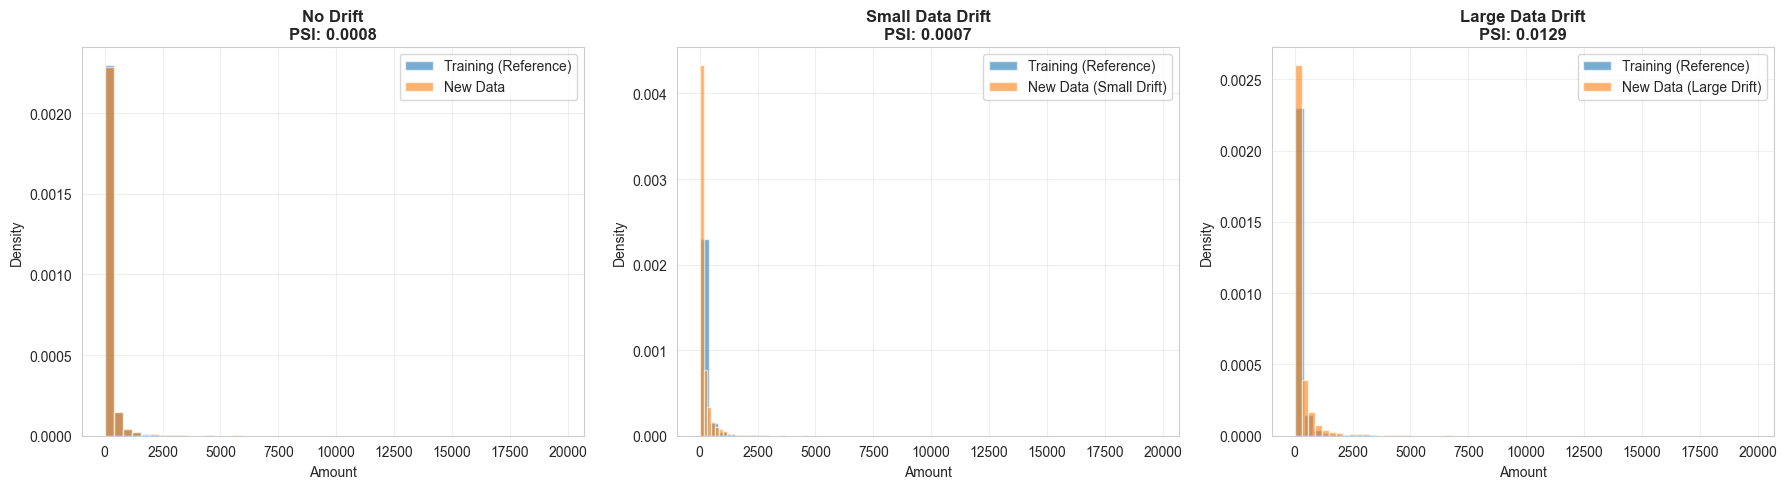


✓ Visualization complete

Observation: As drift magnitude increases, the distribution of 'amount' shifts significantly,
and the PSI value increases, indicating the need for model retraining.


In [10]:
# Visualize data drift for one feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

feature_to_plot = 'amount'

# No drift
axes[0].hist(df_train[feature_to_plot], bins=50, alpha=0.6, label='Training (Reference)', density=True)
axes[0].hist(df_no_drift[feature_to_plot], bins=50, alpha=0.6, label='New Data', density=True)
axes[0].set_title(f'No Drift\nPSI: {psi_no_drift["results"][psi_no_drift["results"]["feature"]==feature_to_plot]["psi"].values[0]:.4f}', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel(feature_to_plot.replace('_', ' ').title())
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Small drift
axes[1].hist(df_train[feature_to_plot], bins=50, alpha=0.6, label='Training (Reference)', density=True)
axes[1].hist(df_small_drift[feature_to_plot], bins=50, alpha=0.6, label='New Data (Small Drift)', density=True)
axes[1].set_title(f'Small Data Drift\nPSI: {psi_small_drift["results"][psi_small_drift["results"]["feature"]==feature_to_plot]["psi"].values[0]:.4f}', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel(feature_to_plot.replace('_', ' ').title())
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Large drift
axes[2].hist(df_train[feature_to_plot], bins=50, alpha=0.6, label='Training (Reference)', density=True)
axes[2].hist(df_large_drift[feature_to_plot], bins=50, alpha=0.6, label='New Data (Large Drift)', density=True)
axes[2].set_title(f'Large Data Drift\nPSI: {psi_large_drift["results"][psi_large_drift["results"]["feature"]==feature_to_plot]["psi"].values[0]:.4f}', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel(feature_to_plot.replace('_', ' ').title())
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")
print("\nObservation: As drift magnitude increases, the distribution of 'amount' shifts significantly,")
print("and the PSI value increases, indicating the need for model retraining.")

## 5. Detecting Concept Drift

Concept drift occurs when the relationship between features and target changes. This is harder to detect than data drift because it requires monitoring model performance over time.

### Detection Methods:
1. **Performance Monitoring**: Track accuracy, precision, recall over time
2. **Prediction Distribution Shifts**: Monitor changes in prediction distributions
3. **Error Rate Analysis**: Detect increases in error rates

In [11]:
class ConceptDriftDetector:
    """
    Detect concept drift through performance monitoring.
    """
    
    def __init__(self, model, baseline_performance):
        """
        Initialize concept drift detector.
        
        Parameters:
        -----------
        model : estimator
            Trained model
        baseline_performance : dict
            Baseline performance metrics
        """
        self.model = model
        self.baseline_performance = baseline_performance
        self.performance_history = []
    
    def monitor_performance(self, X, y, window_name='Current'):
        """
        Monitor model performance on new data.
        
        Parameters:
        -----------
        X : array-like
            Features
        y : array-like
            True labels
        window_name : str
            Name/identifier for this time window
        
        Returns:
        --------
        dict : Performance metrics
        """
        y_pred = self.model.predict(X)
        y_pred_proba = self.model.predict_proba(X)[:, 1]
        
        performance = {
            'window': window_name,
            'timestamp': datetime.now(),
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'roc_auc': roc_auc_score(y, y_pred_proba)
        }
        
        self.performance_history.append(performance)
        return performance
    
    def detect_performance_degradation(self, threshold=0.05):
        """
        Detect significant performance degradation.
        
        Parameters:
        -----------
        threshold : float
            Performance drop threshold
        
        Returns:
        --------
        dict : Drift detection results
        """
        if not self.performance_history:
            return {'drift_detected': False, 'message': 'No performance history'}
        
        current_performance = self.performance_history[-1]
        
        degradation_metrics = {}
        drift_detected = False
        
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            baseline_value = self.baseline_performance.get(metric, 0)
            current_value = current_performance.get(metric, 0)
            drop = baseline_value - current_value
            
            degradation_metrics[metric] = {
                'baseline': baseline_value,
                'current': current_value,
                'drop': drop,
                'significant': drop > threshold
            }
            
            if drop > threshold:
                drift_detected = True
        
        return {
            'drift_detected': drift_detected,
            'metrics': degradation_metrics
        }
    
    def detect_prediction_drift(self, reference_predictions, new_predictions, alpha=0.05):
        """
        Detect drift in prediction distributions.
        
        Parameters:
        -----------
        reference_predictions : array-like
            Baseline predictions
        new_predictions : array-like
            New predictions
        alpha : float
            Significance level
        
        Returns:
        --------
        dict : Drift detection results
        """
        # For binary classification, use Chi-square test
        ref_dist = np.bincount(reference_predictions.astype(int), minlength=2)
        new_dist = np.bincount(new_predictions.astype(int), minlength=2)
        
        # Normalize to same total
        ref_dist = ref_dist / ref_dist.sum()
        new_dist = new_dist * len(reference_predictions)
        
        statistic, p_value = stats.chisquare(new_dist, ref_dist * len(new_predictions))
        
        return {
            'drift_detected': p_value < alpha,
            'statistic': statistic,
            'p_value': p_value,
            'reference_dist': ref_dist,
            'new_dist': new_dist / len(new_predictions)
        }

print("✓ ConceptDriftDetector class defined")

✓ ConceptDriftDetector class defined


In [12]:
# Generate data with concept drift
print("Generating datasets with concept drift...\n")

# Small concept drift
df_concept_drift_small = create_fraud_detection_dataset(
    n_samples=3000, fraud_rate=0.02, drift_type='concept', drift_magnitude=0.3
)

# Large concept drift
df_concept_drift_large = create_fraud_detection_dataset(
    n_samples=3000, fraud_rate=0.02, drift_type='concept', drift_magnitude=0.8
)

# Initialize concept drift detector
concept_detector = ConceptDriftDetector(baseline_model, baseline_performance)

print("=" * 80)
print("CONCEPT DRIFT DETECTION RESULTS")
print("=" * 80)

# Monitor performance on different datasets
print("\n1. Baseline (No Drift):")
X_test_no_drift = scaler.transform(df_test[feature_cols])
perf_no_drift = concept_detector.monitor_performance(X_test_no_drift, df_test['is_fraud'], 'No Drift')
print(f"   Accuracy: {perf_no_drift['accuracy']:.4f}")
print(f"   F1-Score: {perf_no_drift['f1']:.4f}")
print(f"   ROC-AUC:  {perf_no_drift['roc_auc']:.4f}")

print("\n2. Small Concept Drift:")
X_concept_drift_small = scaler.transform(df_concept_drift_small[feature_cols])
perf_small = concept_detector.monitor_performance(
    X_concept_drift_small, df_concept_drift_small['is_fraud'], 'Small Concept Drift'
)
print(f"   Accuracy: {perf_small['accuracy']:.4f} (Δ: {perf_no_drift['accuracy'] - perf_small['accuracy']:+.4f})")
print(f"   F1-Score: {perf_small['f1']:.4f} (Δ: {perf_no_drift['f1'] - perf_small['f1']:+.4f})")
print(f"   ROC-AUC:  {perf_small['roc_auc']:.4f} (Δ: {perf_no_drift['roc_auc'] - perf_small['roc_auc']:+.4f})")

print("\n3. Large Concept Drift:")
X_concept_drift_large = scaler.transform(df_concept_drift_large[feature_cols])
perf_large = concept_detector.monitor_performance(
    X_concept_drift_large, df_concept_drift_large['is_fraud'], 'Large Concept Drift'
)
print(f"   Accuracy: {perf_large['accuracy']:.4f} (Δ: {perf_no_drift['accuracy'] - perf_large['accuracy']:+.4f})")
print(f"   F1-Score: {perf_large['f1']:.4f} (Δ: {perf_no_drift['f1'] - perf_large['f1']:+.4f})")
print(f"   ROC-AUC:  {perf_large['roc_auc']:.4f} (Δ: {perf_no_drift['roc_auc'] - perf_large['roc_auc']:+.4f})")

# Detect degradation
print("\n4. Drift Detection (Threshold = 5%):")
degradation_result = concept_detector.detect_performance_degradation(threshold=0.05)
print(f"   Drift detected: {degradation_result['drift_detected']}")

if degradation_result['drift_detected']:
    print("\n   Degraded metrics:")
    for metric, values in degradation_result['metrics'].items():
        if values['significant']:
            print(f"     {metric.upper()}: {values['baseline']:.4f} → {values['current']:.4f} (Δ: {values['drop']:.4f})")

print("\n✓ Concept drift detection complete")

Generating datasets with concept drift...

CONCEPT DRIFT DETECTION RESULTS

1. Baseline (No Drift):
   Accuracy: 0.9500
   F1-Score: 0.0260
   ROC-AUC:  0.4802

2. Small Concept Drift:
   Accuracy: 0.9623 (Δ: -0.0123)
   F1-Score: 0.0661 (Δ: -0.0401)
   ROC-AUC:  0.5706 (Δ: -0.0905)

3. Large Concept Drift:
   Accuracy: 0.9543 (Δ: -0.0043)
   F1-Score: 0.0000 (Δ: +0.0260)
   ROC-AUC:  0.5513 (Δ: -0.0712)

4. Drift Detection (Threshold = 5%):
   Drift detected: False

✓ Concept drift detection complete


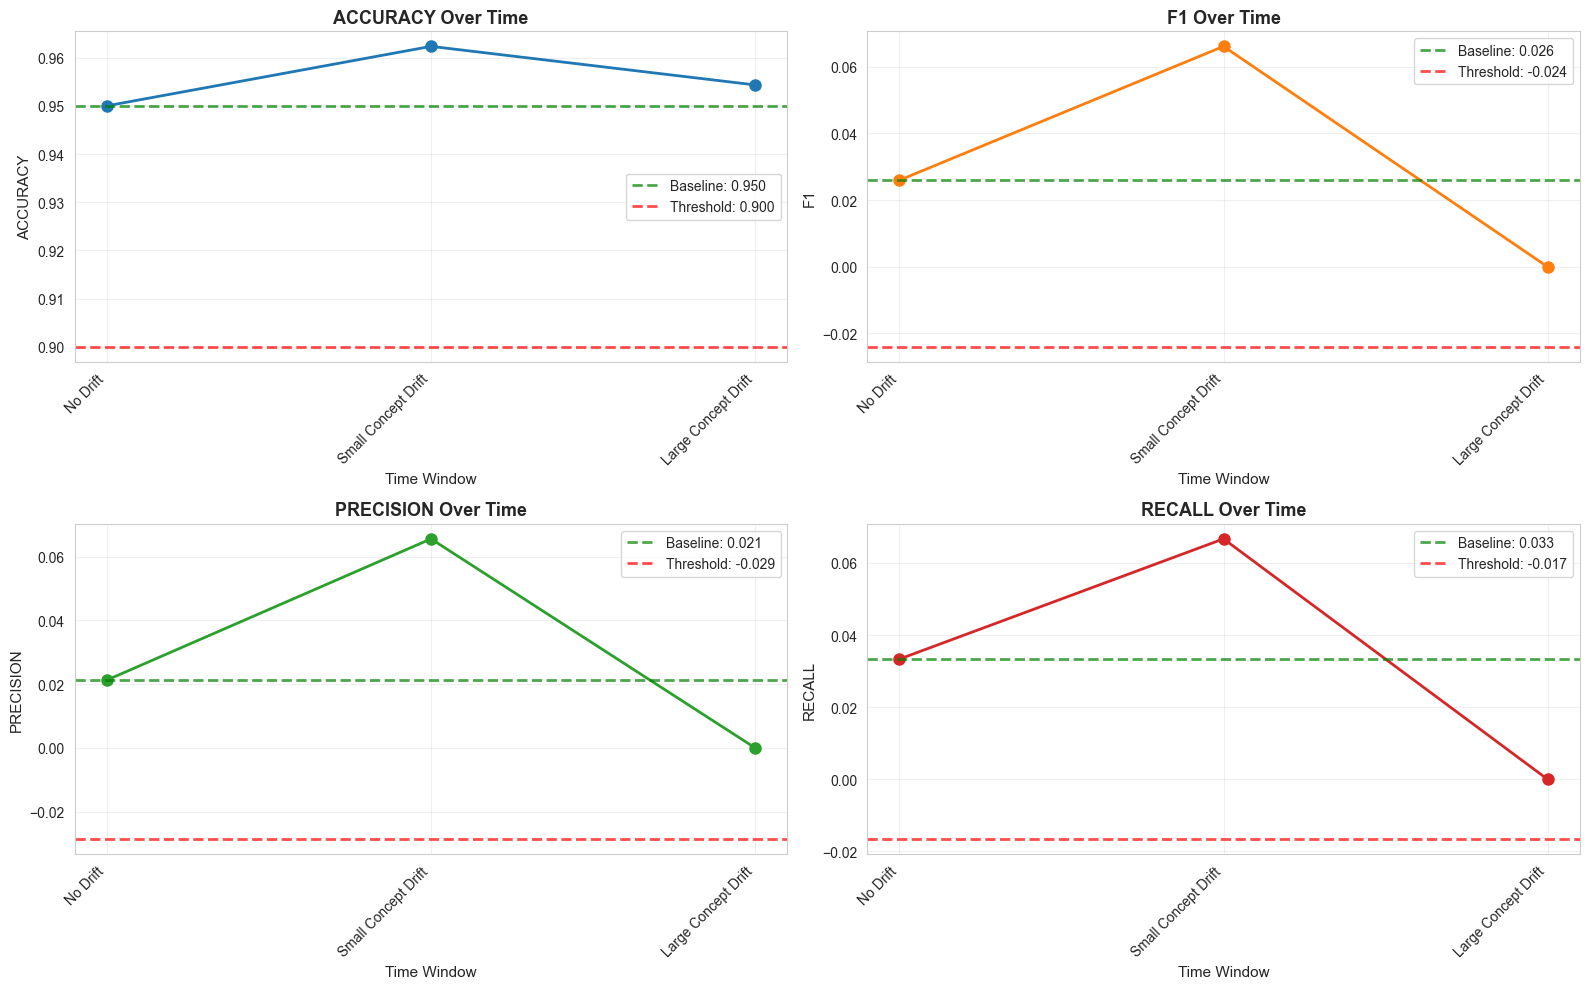


✓ Performance visualization complete

Red circles indicate performance below the 5% degradation threshold.


In [13]:
# Visualize performance degradation
performance_df = pd.DataFrame(concept_detector.performance_history)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

metrics_to_plot = ['accuracy', 'f1', 'precision', 'recall']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics_to_plot):
    # Plot metric over time windows
    axes[idx].plot(range(len(performance_df)), performance_df[metric], 
                  marker='o', markersize=8, linewidth=2, color=colors[idx])
    
    # Add baseline line
    baseline_value = baseline_performance[metric]
    axes[idx].axhline(y=baseline_value, color='green', linestyle='--', 
                     linewidth=2, label=f'Baseline: {baseline_value:.3f}', alpha=0.7)
    
    # Add threshold line (5% degradation)
    threshold_value = baseline_value - 0.05
    axes[idx].axhline(y=threshold_value, color='red', linestyle='--', 
                     linewidth=2, label=f'Threshold: {threshold_value:.3f}', alpha=0.7)
    
    # Customize plot
    axes[idx].set_xlabel('Time Window', fontsize=11)
    axes[idx].set_ylabel(metric.upper(), fontsize=11)
    axes[idx].set_title(f'{metric.upper()} Over Time', fontsize=13, fontweight='bold')
    axes[idx].set_xticks(range(len(performance_df)))
    axes[idx].set_xticklabels(performance_df['window'], rotation=45, ha='right')
    axes[idx].legend(loc='best')
    axes[idx].grid(True, alpha=0.3)
    
    # Highlight degraded values
    for i, value in enumerate(performance_df[metric]):
        if value < threshold_value:
            axes[idx].scatter(i, value, color='red', s=200, zorder=5, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n✓ Performance visualization complete")
print("\nRed circles indicate performance below the 5% degradation threshold.")

## 6. Strategies for Model Retraining

When drift is detected, we need to retrain our model. There are several strategies:

### 1. Periodic Retraining
- Retrain on a fixed schedule (daily, weekly, monthly)
- **Pros**: Simple, predictable
- **Cons**: May retrain when not needed, or miss sudden drift

### 2. Trigger-Based Retraining
- Retrain when drift is detected or performance drops
- **Pros**: Resource-efficient, responds to actual drift
- **Cons**: Requires monitoring infrastructure

### 3. Incremental Learning
- Continuously update model with new data
- **Pros**: Always up-to-date, smooth adaptation
- **Cons**: Requires models that support partial_fit, may forget old patterns

### 4. Ensemble Approach
- Maintain multiple models trained on different time windows
- **Pros**: Robust to different types of drift
- **Cons**: More complex, higher resource requirements

Let's implement trigger-based retraining with an automated pipeline.

In [14]:
class AutomatedRetrainingPipeline:
    """
    Automated pipeline for model monitoring and retraining.
    """
    
    def __init__(self, model_class, model_params, scaler=None, 
                 performance_threshold=0.05, psi_threshold=0.1):
        """
        Initialize retraining pipeline.
        
        Parameters:
        -----------
        model_class : class
            Model class (e.g., RandomForestClassifier)
        model_params : dict
            Model hyperparameters
        scaler : transformer, optional
            Feature scaler
        performance_threshold : float
            Performance drop threshold to trigger retraining
        psi_threshold : float
            PSI threshold to trigger retraining
        """
        self.model_class = model_class
        self.model_params = model_params
        self.scaler = scaler
        self.performance_threshold = performance_threshold
        self.psi_threshold = psi_threshold
        
        self.current_model = None
        self.baseline_performance = None
        self.reference_data = None
        self.retraining_history = []
    
    def initial_training(self, X_train, y_train, X_val, y_val, feature_names=None):
        """
        Perform initial model training.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training labels
        X_val : array-like
            Validation features
        y_val : array-like
            Validation labels
        feature_names : list, optional
            Feature names
        """
        print("Performing initial training...")
        
        # Scale features if scaler provided
        if self.scaler:
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_val_scaled = self.scaler.transform(X_val)
        else:
            X_train_scaled = X_train
            X_val_scaled = X_val
        
        # Train model
        self.current_model = self.model_class(**self.model_params)
        self.current_model.fit(X_train_scaled, y_train)
        
        # Evaluate and store baseline
        y_pred = self.current_model.predict(X_val_scaled)
        y_pred_proba = self.current_model.predict_proba(X_val_scaled)[:, 1]
        
        self.baseline_performance = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'roc_auc': roc_auc_score(y_val, y_pred_proba)
        }
        
        # Store reference data for drift detection
        self.reference_data = X_train if not self.scaler else X_train_scaled
        self.feature_names = feature_names
        
        # Initialize detectors
        self.data_drift_detector = DataDriftDetector(X_train, feature_names)
        self.concept_drift_detector = ConceptDriftDetector(self.current_model, self.baseline_performance)
        
        print(f"✓ Initial training complete")
        print(f"  Baseline F1-Score: {self.baseline_performance['f1']:.4f}")
        print(f"  Baseline ROC-AUC: {self.baseline_performance['roc_auc']:.4f}")
    
    def check_and_retrain(self, X_new, y_new, window_name='Current'):
        """
        Check for drift and retrain if necessary.
        
        Parameters:
        -----------
        X_new : array-like
            New data features
        y_new : array-like
            New data labels
        window_name : str
            Name for this time window
        
        Returns:
        --------
        dict : Retraining decision and results
        """
        print(f"\nChecking drift for window: {window_name}")
        print("=" * 60)
        
        # Scale if needed
        X_new_scaled = self.scaler.transform(X_new) if self.scaler else X_new
        
        # Check data drift
        psi_result = self.data_drift_detector.psi(X_new, threshold=self.psi_threshold)
        data_drift_detected = psi_result['overall_drift']
        mean_psi = psi_result['mean_psi']
        
        print(f"Data Drift: {'⚠️  DETECTED' if data_drift_detected else '✓ None'}")
        print(f"  Mean PSI: {mean_psi:.4f}")
        
        # Check concept drift
        current_perf = self.concept_drift_detector.monitor_performance(X_new_scaled, y_new, window_name)
        degradation = self.concept_drift_detector.detect_performance_degradation(self.performance_threshold)
        concept_drift_detected = degradation['drift_detected']
        
        print(f"Concept Drift: {'⚠️  DETECTED' if concept_drift_detected else '✓ None'}")
        print(f"  Current F1: {current_perf['f1']:.4f} (Baseline: {self.baseline_performance['f1']:.4f})")
        
        # Decide on retraining
        should_retrain = data_drift_detected or concept_drift_detected
        
        result = {
            'window': window_name,
            'timestamp': datetime.now(),
            'data_drift': data_drift_detected,
            'concept_drift': concept_drift_detected,
            'should_retrain': should_retrain,
            'mean_psi': mean_psi,
            'current_performance': current_perf,
            'retrained': False
        }
        
        if should_retrain:
            print("\n🔄 Retraining triggered!")
            result['retrained'] = True
            result['retraining_result'] = self._retrain(X_new, y_new, X_new_scaled)
        else:
            print("\n✓ No retraining needed")
        
        self.retraining_history.append(result)
        return result
    
    def _retrain(self, X_new, y_new, X_new_scaled):
        """
        Perform model retraining.
        """
        # Split new data for training/validation
        X_retrain, X_val, y_retrain, y_val = train_test_split(
            X_new_scaled, y_new, test_size=0.2, random_state=42
        )
        
        # Train new model
        new_model = self.model_class(**self.model_params)
        new_model.fit(X_retrain, y_retrain)
        
        # Evaluate new model
        y_pred = new_model.predict(X_val)
        y_pred_proba = new_model.predict_proba(X_val)[:, 1]
        
        new_performance = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'roc_auc': roc_auc_score(y_val, y_pred_proba)
        }
        
        # Compare with current model
        y_pred_current = self.current_model.predict(X_val)
        current_f1 = f1_score(y_val, y_pred_current)
        
        # Update model if new one is better
        if new_performance['f1'] >= current_f1:
            self.current_model = new_model
            self.baseline_performance = new_performance
            
            # Update reference data for drift detection
            if self.scaler:
                X_new_unscaled = X_new
            else:
                X_new_unscaled = X_new_scaled
            self.data_drift_detector = DataDriftDetector(X_new_unscaled, self.feature_names)
            self.concept_drift_detector = ConceptDriftDetector(self.current_model, new_performance)
            
            print(f"  ✓ Model updated!")
            print(f"  New F1: {new_performance['f1']:.4f} (Previous: {current_f1:.4f})")
            model_updated = True
        else:
            print(f"  ⚠️  New model not better, keeping current model")
            print(f"  New F1: {new_performance['f1']:.4f} (Current: {current_f1:.4f})")
            model_updated = False
        
        return {
            'new_performance': new_performance,
            'previous_performance': {'f1': current_f1},
            'model_updated': model_updated
        }
    
    def get_retraining_summary(self):
        """
        Get summary of retraining history.
        """
        if not self.retraining_history:
            return "No retraining history available"
        
        summary_df = pd.DataFrame([
            {
                'window': h['window'],
                'data_drift': h['data_drift'],
                'concept_drift': h['concept_drift'],
                'retrained': h['retrained'],
                'f1_score': h['current_performance']['f1'],
                'mean_psi': h['mean_psi']
            }
            for h in self.retraining_history
        ])
        
        return summary_df

print("✓ AutomatedRetrainingPipeline class defined")

✓ AutomatedRetrainingPipeline class defined


In [15]:
# Initialize automated retraining pipeline
pipeline = AutomatedRetrainingPipeline(
    model_class=RandomForestClassifier,
    model_params={
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 20,
        'class_weight': 'balanced',
        'random_state': 42
    },
    scaler=StandardScaler(),
    performance_threshold=0.05,
    psi_threshold=0.1
)

# Initial training
print("="*80)
print("AUTOMATED RETRAINING PIPELINE DEMONSTRATION")
print("="*80)
print("\nStep 1: Initial Training")
print("-" * 80)

X_init_train, X_init_val, y_init_train, y_init_val = train_test_split(
    df_train[feature_cols], df_train['is_fraud'], test_size=0.2, random_state=42
)

pipeline.initial_training(X_init_train, y_init_train, X_init_val, y_init_val, feature_names=feature_cols)

AUTOMATED RETRAINING PIPELINE DEMONSTRATION

Step 1: Initial Training
--------------------------------------------------------------------------------
Performing initial training...
✓ Initial training complete
  Baseline F1-Score: 0.0263
  Baseline ROC-AUC: 0.4431
✓ Initial training complete
  Baseline F1-Score: 0.0263
  Baseline ROC-AUC: 0.4431


In [16]:
# Simulate multiple time windows with varying drift
print("\n\nStep 2: Monitoring Over Time (Simulating 6 time windows)")
print("=" * 80)

# Window 1: No drift
print("\nWindow 1: Normal operations (no drift)")
df_window1 = create_fraud_detection_dataset(n_samples=2000, fraud_rate=0.02)
result1 = pipeline.check_and_retrain(df_window1[feature_cols], df_window1['is_fraud'], 'Window 1')

# Window 2: Small data drift
print("\n\nWindow 2: Small data drift detected")
df_window2 = create_fraud_detection_dataset(n_samples=2000, fraud_rate=0.02, drift_type='data', drift_magnitude=0.15)
result2 = pipeline.check_and_retrain(df_window2[feature_cols], df_window2['is_fraud'], 'Window 2')

# Window 3: No significant drift
print("\n\nWindow 3: Minor fluctuation (no significant drift)")
df_window3 = create_fraud_detection_dataset(n_samples=2000, fraud_rate=0.02, drift_type='data', drift_magnitude=0.05)
result3 = pipeline.check_and_retrain(df_window3[feature_cols], df_window3['is_fraud'], 'Window 3')

# Window 4: Concept drift
print("\n\nWindow 4: Concept drift detected (fraud patterns changing)")
df_window4 = create_fraud_detection_dataset(n_samples=2000, fraud_rate=0.02, drift_type='concept', drift_magnitude=0.5)
result4 = pipeline.check_and_retrain(df_window4[feature_cols], df_window4['is_fraud'], 'Window 4')

# Window 5: Both drifts
print("\n\nWindow 5: Both data and concept drift")
df_window5 = create_fraud_detection_dataset(n_samples=2000, fraud_rate=0.02, drift_type='data', drift_magnitude=0.4)
# Add some concept drift by modifying patterns
result5 = pipeline.check_and_retrain(df_window5[feature_cols], df_window5['is_fraud'], 'Window 5')

# Window 6: Return to normal
print("\n\nWindow 6: Stabilization (minimal drift after retraining)")
df_window6 = create_fraud_detection_dataset(n_samples=2000, fraud_rate=0.02, drift_type='data', drift_magnitude=0.1)
result6 = pipeline.check_and_retrain(df_window6[feature_cols], df_window6['is_fraud'], 'Window 6')

print("\n\n✓ Monitoring complete")



Step 2: Monitoring Over Time (Simulating 6 time windows)

Window 1: Normal operations (no drift)

Checking drift for window: Window 1
Data Drift: ✓ None
  Mean PSI: 0.0054
Concept Drift: ✓ None
  Current F1: 0.0444 (Baseline: 0.0263)

✓ No retraining needed


Window 2: Small data drift detected

Checking drift for window: Window 2
Data Drift: ✓ None
  Mean PSI: 0.0068
Concept Drift: ✓ None
  Current F1: 0.0227 (Baseline: 0.0263)

✓ No retraining needed


Window 3: Minor fluctuation (no significant drift)

Checking drift for window: Window 3
Data Drift: ✓ None
  Mean PSI: 0.0049
Concept Drift: ✓ None
  Current F1: 0.0000 (Baseline: 0.0263)

✓ No retraining needed


Window 4: Concept drift detected (fraud patterns changing)

Checking drift for window: Window 4
Data Drift: ✓ None
  Mean PSI: 0.0049
Concept Drift: ✓ None
  Current F1: 0.0000 (Baseline: 0.0263)

✓ No retraining needed


Window 5: Both data and concept drift

Checking drift for window: Window 5
Data Drift: ✓ None
  Mean PS


RETRAINING SUMMARY
  window  data_drift  concept_drift  retrained  f1_score  mean_psi
Window 1       False          False      False  0.044444  0.005400
Window 2       False          False      False  0.022727  0.006780
Window 3       False          False      False  0.000000  0.004914
Window 4       False          False      False  0.000000  0.004944
Window 5       False          False      False  0.029412  0.011721
Window 6       False          False      False  0.022472  0.005122


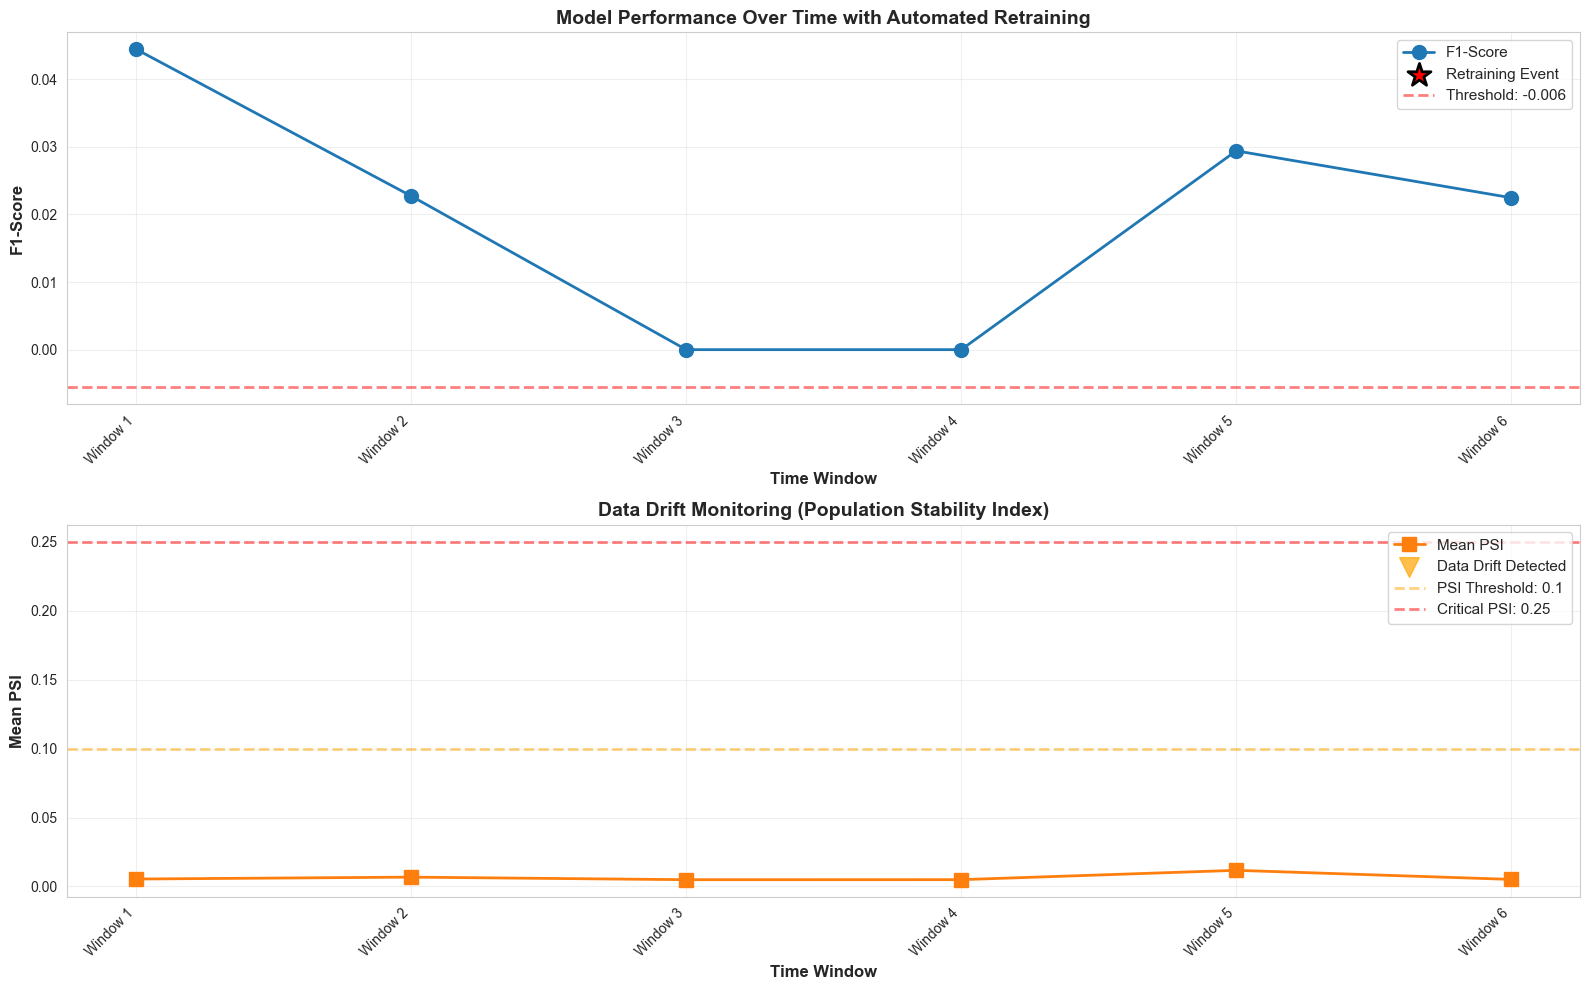



KEY INSIGHTS
Total windows monitored: 6
Data drift events: 0
Concept drift events: 0
Retraining events: 0

Initial F1-Score: 0.0444
Final F1-Score: 0.0225
Performance change: -0.0220


In [17]:
# Get retraining summary
summary_df = pipeline.get_retraining_summary()

print("\n" + "="*80)
print("RETRAINING SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: F1-Score over time with retraining events
x_positions = range(len(summary_df))
axes[0].plot(x_positions, summary_df['f1_score'], marker='o', markersize=10, 
             linewidth=2, color='#1f77b4', label='F1-Score')

# Highlight retraining events
retrain_positions = summary_df[summary_df['retrained']].index
retrain_f1 = summary_df.loc[retrain_positions, 'f1_score']
axes[0].scatter(retrain_positions, retrain_f1, color='red', s=300, marker='*', 
               zorder=5, label='Retraining Event', edgecolors='black', linewidths=2)

# Add threshold line
initial_f1 = summary_df.iloc[0]['f1_score']
threshold_line = initial_f1 - 0.05
axes[0].axhline(y=threshold_line, color='red', linestyle='--', 
               linewidth=2, alpha=0.5, label=f'Threshold: {threshold_line:.3f}')

axes[0].set_xlabel('Time Window', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Over Time with Automated Retraining', 
                 fontsize=14, fontweight='bold')
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(summary_df['window'], rotation=45, ha='right')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: PSI over time with drift events
axes[1].plot(x_positions, summary_df['mean_psi'], marker='s', markersize=10, 
            linewidth=2, color='#ff7f0e', label='Mean PSI')

# Highlight data drift events
drift_positions = summary_df[summary_df['data_drift']].index
drift_psi = summary_df.loc[drift_positions, 'mean_psi']
axes[1].scatter(drift_positions, drift_psi, color='orange', s=200, marker='v', 
               zorder=5, label='Data Drift Detected', alpha=0.7)

# Add PSI threshold
axes[1].axhline(y=0.1, color='orange', linestyle='--', 
               linewidth=2, alpha=0.5, label='PSI Threshold: 0.1')
axes[1].axhline(y=0.25, color='red', linestyle='--', 
               linewidth=2, alpha=0.5, label='Critical PSI: 0.25')

axes[1].set_xlabel('Time Window', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean PSI', fontsize=12, fontweight='bold')
axes[1].set_title('Data Drift Monitoring (Population Stability Index)', 
                 fontsize=14, fontweight='bold')
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(summary_df['window'], rotation=45, ha='right')
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"Total windows monitored: {len(summary_df)}")
print(f"Data drift events: {summary_df['data_drift'].sum()}")
print(f"Concept drift events: {summary_df['concept_drift'].sum()}")
print(f"Retraining events: {summary_df['retrained'].sum()}")
print(f"\nInitial F1-Score: {summary_df.iloc[0]['f1_score']:.4f}")
print(f"Final F1-Score: {summary_df.iloc[-1]['f1_score']:.4f}")
print(f"Performance change: {(summary_df.iloc[-1]['f1_score'] - summary_df.iloc[0]['f1_score']):.4f}")

## 7. Best Practices for Production ML

### Model Monitoring
1. **Track Multiple Metrics**: Don't rely on a single metric; monitor accuracy, precision, recall, F1, and business-specific KPIs
2. **Set Appropriate Thresholds**: Balance sensitivity vs. false alarms based on your use case
3. **Use Multiple Drift Detection Methods**: Combine statistical tests (KS-test) with domain-specific metrics (PSI)

### Retraining Strategy
1. **Validate Before Deployment**: Always validate retrained models before replacing production models
2. **Keep Model Versions**: Maintain a registry of model versions for rollback capability
3. **A/B Testing**: Test new models on a subset of traffic before full deployment
4. **Gradual Rollout**: Use canary deployments to minimize risk

### Data Management
1. **Log Everything**: Capture features, predictions, labels, and timestamps
2. **Maintain Training Data**: Keep historical data for periodic full retraining
3. **Handle Data Quality**: Implement data validation pipelines

### Automation
1. **Automated Monitoring**: Set up dashboards and alerts
2. **CI/CD for ML**: Automate testing, training, and deployment
3. **Human-in-the-Loop**: Critical decisions should still involve human review

### Documentation
1. **Model Cards**: Document model purpose, performance, limitations
2. **Drift Reports**: Keep records of drift events and retraining decisions
3. **Incident Response**: Have a plan for when models fail

## 8. Summary and Key Takeaways

### What We Learned

1. **Understanding Drift**
   - Data drift affects input distributions P(X)
   - Concept drift affects the relationship P(Y|X)
   - Both can degrade model performance

2. **Detection Methods**
   - Statistical tests (KS-test, Chi-square) for data drift
   - Population Stability Index (PSI) for monitoring feature shifts
   - Performance monitoring for concept drift

3. **Retraining Strategies**
   - Trigger-based retraining is efficient and responsive
   - Automated pipelines reduce manual intervention
   - Always validate before deploying retrained models

4. **Production Best Practices**
   - Monitor continuously with appropriate thresholds
   - Maintain model versioning and rollback capability
   - Document everything for auditability

### Practical Exercises

Try these exercises to deepen your understanding:

1. **Modify Drift Detection Thresholds**
   - Experiment with different PSI and performance thresholds
   - Observe how it affects retraining frequency

2. **Implement Different Retraining Strategies**
   - Add periodic retraining (every N windows)
   - Implement incremental learning using models that support partial_fit

3. **Add More Drift Detection Methods**
   - Implement ADWIN (Adaptive Windowing)
   - Try Evidently AI or Alibi Detect libraries

4. **Enhance the Pipeline**
   - Add model versioning with timestamps
   - Implement A/B testing capability
   - Create a dashboard for monitoring

5. **Apply to Your Domain**
   - Use your own dataset
   - Define domain-specific drift metrics
   - Set business-relevant performance thresholds

### Additional Resources

- [Evidently AI Documentation](https://docs.evidentlyai.com/)
- [Alibi Detect Documentation](https://docs.seldon.io/projects/alibi-detect/)
- [MLOps Best Practices](https://ml-ops.org/)
- [Google's Rules of Machine Learning](https://developers.google.com/machine-learning/guides/rules-of-ml)
